# Импорт библиотек

In [519]:
from turbine.average_streamline.turbine import Turbine
from turbine.profiling.turbine import TurbineProfiler
from turbine.profiling.stage import ProfilingType, StageProfiler
from turbine.profiling.section import BladeSection
import numpy as np
import pickle
from gas_turbine_cycle.gases import Air
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import config
import os
from turbine.cooling.film_defl import get_sa_cooler, FilmBladeCooler, LocalParamCalculator, FilmSectorCooler

## Загрузка результатов расчета по средней линии

In [520]:
def get_turbibe_calc_res(fname):
    file = open(fname, 'rb')
    res = pickle.load(file)
    file.close()
    return res
turbine_calc_res = get_turbibe_calc_res(os.path.join(config.output_dirname, 'comp_turbine_ave_line.avl'))
turbine: Turbine = turbine_calc_res['turbine']
prof_types = turbine_calc_res['profiling_type_list']

## Профили параметров на входе в СА первой ступени

# Профилирование

In [521]:
c_in = 100
alpha_in = np.radians(90)
p_in_stag = turbine[0].p0_stag
T_in_stag = turbine[0].T0_stag

profiler = TurbineProfiler(turbine=turbine, 
                           p_in_stag=lambda r: p_in_stag, 
                           T_in_stag=lambda r: T_in_stag, 
                           alpha_in=lambda r: alpha_in, 
                           c_in=lambda r: c_in, 
                           section_num=7, pnt_cnt=150, center=True)

stage1_prof: StageProfiler = profiler[0]
stage2_prof: StageProfiler = profiler[1]

init_params = pd.DataFrame.from_dict({'Name': ['p_вх*, МПа', 'T_вх*, К', 'alpha_вх, град', 'c_вх, м/с'], 
                                      'Value': [round(p_in_stag / 1e6, 4), 
                                                round(T_in_stag, 2), 
                                                np.degrees(alpha_in), 
                                                c_in
                                               ]})
init_params

,Name,Value
0,"p_вх*, МПа",1.6712
1,"T_вх*, К",1523.0000
2,"alpha_вх, град",90.0000
3,"c_вх, м/с",100.0000


In [522]:
def get_gas_dynamic_params(stage_profiler: StageProfiler, rad: float):
    params = pd.DataFrame.from_dict({'Name': ['r, мм','rho', 'c1, м/с', 'c1_a, м/с', 'c1_u, м/с', 'alpha1, град', 
                                             'w1, м/с', 'w1_a, м/с', 'w1_u, м/с', 'beta1, град', 'u, м/с',
                                             'p1, МПа', 'T1, К', 'T1_w_stag, К',
                                             'c2, м/с', 'c2_a, м/с', 'c2_u, м/с', 'alpha2, град', 
                                             'w2, м/с', 'w2_a, м/с', 'w2_u, м/с', 'beta2, град', 
                                             'T2, К', 'p2, МПа',
                                             'M_c0', 'M_c1', 'M_w1', 'M_w2'], 
                                    'Value': [round(rad * 1e3, 1),
                                             stage_profiler.rho(rad),
                                             stage_profiler.c1(rad),
                                             stage_profiler.c1_a(rad),
                                             stage_profiler.c1_u(rad),
                                             np.degrees(stage_profiler.alpha1(rad)),
                                             stage_profiler.w1(rad),
                                             stage_profiler.w1_a(rad),
                                             stage_profiler.w1_u(rad),
                                             np.degrees(stage_profiler.beta1(rad)),
                                             stage_profiler.u(rad),
                                             stage_profiler.p1(rad) / 1e6,
                                             stage_profiler.T1(rad),
                                             stage_profiler.T1_w_stag(rad),
                                              
                                             stage_profiler.c2(rad),
                                             stage_profiler.c2_a(rad),
                                             stage_profiler.c2_u(rad),
                                             np.degrees(stage_profiler.alpha2(rad)),
                                             stage_profiler.w2(rad),
                                             stage_profiler.w2_a(rad),
                                             stage_profiler.w2_u(rad),
                                             np.degrees(stage_profiler.beta2(rad)),
                                             stage_profiler.T2(rad),
                                             stage_profiler.p2(rad) / 1e6,
                                             stage_profiler.M_c0(rad),
                                             stage_profiler.M_c1(rad),
                                             stage_profiler.M_w1(rad),
                                             stage_profiler.M_w2(rad)]})
    return params

def get_section_geom_params(section: BladeSection, stage_profiler: StageProfiler):
    params = pd.DataFrame.from_dict({'Name': ['alpha1, град', 'delta1, град', 'alpha1_л, град', 
                                              'gamma1, град', 'gamma1_к, град', 'gamma1_c, град',
                                              'alpha2, град', 'delta2, град', 'alpha2_л, град',
                                              'gamma2, град', 'gamma2_к, град', 'gamma2_с, град',
                                              'r1, см', 's2, см', 't, см', 'b, см', 't/b', 'S, см^2', 'l, см'], 
                                    'Value': [np.degrees(section.angle1),
                                              np.degrees(section.delta1),
                                              np.degrees(section.angle1_l),
                                              np.degrees(section.gamma1_s + section.gamma1_k),
                                              np.degrees(section.gamma1_k),
                                              np.degrees(section.gamma1_s),
                                              np.degrees(section.angle2),
                                              np.degrees(section.delta2),
                                              np.degrees(section.angle2_l),
                                              np.degrees(section.gamma2_s + section.gamma2_k),
                                              np.degrees(section.gamma2_k),
                                              np.degrees(section.gamma2_s),
                                              section.r1 * 1e2,
                                              section.s2 * 1e2,
                                              section.t * 1e2,
                                              section.chord_length * 1e2,
                                              section.t_rel,
                                              section.square_y * 1e4,
                                              0.5 * (stage_profiler.D1_out - stage_profiler.D1_in) * 1e2]})
    return params

## Параметры для профилирования ступеней

## Ступень 1

In [523]:
stage1_prof.auto_sections_par = True
stage1_prof.profiling_type = prof_types[0]
stage1_prof.t_rel_av_sa = 0.80
stage1_prof.t_rel_av_rk = 0.75
stage1_prof.r1_rel_sa = lambda r_rel: 0.070
stage1_prof.r1_rel_rk = lambda r_rel: 0.08 - 0.025 * r_rel
stage1_prof.gamma1_k_rel_sa = lambda r_rel: 0.15
stage1_prof.gamma1_k_rel_rk = lambda r_rel: interp1d([0, 0.5, 1], [0.55, 0.35, 0.2])(r_rel)
stage1_prof.gamma2_k_rel_sa = lambda r_rel: 0.15
stage1_prof.gamma2_k_rel_rk = lambda r_rel: 0.15
stage1_prof.center_point_sa = lambda r_rel: 0.75
stage1_prof.center_point_rk = lambda r_rel: interp1d([0, 0.5, 1], [0.41, 0.5, 0.62])(r_rel)
stage1_prof.s2_sa = 0.0009
stage1_prof.s2_rk = 0.0009
stage1_prof.gamma1_sa = lambda r_rel: np.radians(24)
stage1_prof.gamma1_rk = lambda r_rel: interp1d([0, 0.5, 1], [np.radians(35), np.radians(27), np.radians(19)])(r_rel)
stage1_prof.gamma2_sa = np.radians(5)
stage1_prof.gamma2_rk = np.radians(5)

st1_params = pd.DataFrame.from_dict({'Name':['Способ профилирования',
                                            '(t/b)_са',
                                            '(t/b)_рк',
                                            'gamma2_са, град',
                                            'gamma2_рк, град'], 
                                     'Value': [str(stage1_prof.profiling_type),
                                              stage1_prof.t_rel_av_sa,
                                              stage1_prof.t_rel_av_rk,
                                              np.degrees(stage1_prof.gamma2_sa),
                                              np.degrees(stage1_prof.gamma2_rk)]
                                    })
st1_params

,Name,Value
0,Способ профилирования,ProfilingType.ConstantAngle
1,(t/b)_са,0.8
2,(t/b)_рк,0.75
3,"gamma2_са, град",5
4,"gamma2_рк, град",5


## Ступень 2

In [524]:
stage2_prof.auto_sections_par = True
stage2_prof.profiling_type = prof_types[1]
stage2_prof.t_rel_av_sa = 0.80
stage2_prof.t_rel_av_rk = 0.75
stage2_prof.r1_rel_sa = lambda r_rel: 0.070
stage2_prof.r1_rel_rk = lambda r_rel: 0.08 - 0.03 * r_rel
stage2_prof.gamma1_k_rel_sa = lambda r_rel: 0.15
stage2_prof.gamma1_k_rel_rk = lambda r_rel: interp1d([0, 0.5, 1], [0.55, 0.35, 0.35])(r_rel)
stage2_prof.gamma2_k_rel_sa = lambda r_rel: 0.15
stage2_prof.gamma2_k_rel_rk = lambda r_rel: 0.15
stage2_prof.center_point_sa = lambda r_rel: 0.75
stage2_prof.center_point_rk = lambda r_rel: interp1d([0, 0.5, 1], [0.4, 0.48, 0.55])(r_rel)
stage2_prof.s2_sa = 0.0009
stage2_prof.s2_rk = 0.0009
stage2_prof.gamma1_sa = lambda r_rel: np.radians(24)
stage2_prof.gamma1_rk = lambda r_rel: interp1d([0, 0.5, 1], [np.radians(34), np.radians(24), np.radians(9)])(r_rel)
stage2_prof.gamma2_sa = np.radians(5)
stage2_prof.gamma2_rk = np.radians(5)

st2_params = pd.DataFrame.from_dict({'Name':['Способ профилирования',
                                             '(t/b)_са',
                                             '(t/b)_рк',
                                             'gamma2_са, град',
                                             'gamma2_рк, град'], 
                                     'Value': [str(stage2_prof.profiling_type),
                                              stage2_prof.t_rel_av_sa,
                                              stage2_prof.t_rel_av_rk,
                                              np.degrees(stage2_prof.gamma2_sa),
                                              np.degrees(stage2_prof.gamma2_rk)]
                                    })
st2_params

,Name,Value
0,Способ профилирования,ProfilingType.ConstantAngle
1,(t/b)_са,0.8
2,(t/b)_рк,0.75
3,"gamma2_са, град",5
4,"gamma2_рк, град",5


## Параметры на отдельных сечениях

In [525]:
st1_sa_sec_in: BladeSection = stage1_prof.sa_sections[0] 
st1_sa_sec_av: BladeSection = stage1_prof.sa_sections[3] 
st1_sa_sec_out: BladeSection = stage1_prof.sa_sections[6] 

st1_rk_sec_in: BladeSection = stage1_prof.rk_sections[0] 
st1_rk_sec_av: BladeSection = stage1_prof.rk_sections[3] 
st1_rk_sec_out: BladeSection = stage1_prof.rk_sections[6] 

st2_sa_sec_in: BladeSection = stage2_prof.sa_sections[0] 
st2_sa_sec_av: BladeSection = stage2_prof.sa_sections[3] 
st2_sa_sec_out: BladeSection = stage2_prof.sa_sections[6] 

st2_rk_sec_in: BladeSection = stage2_prof.rk_sections[0] 
st2_rk_sec_av: BladeSection = stage2_prof.rk_sections[3] 
st2_rk_sec_out: BladeSection = stage2_prof.rk_sections[6] 

## Расчет

In [526]:
profiler.compute_stage_profiles()

C:\ProgramData\Anaconda3\lib\site-packages\turbine\profiling\section.py:817: RuntimeWarning: invalid value encountered in sqrt
  res = self.y01 + np.sqrt(self.r1 ** 2 - (x - self.x01) ** 2)
C:\ProgramData\Anaconda3\lib\site-packages\turbine\profiling\section.py:832: RuntimeWarning: invalid value encountered in sqrt
  res = self.y01 - np.sqrt(self.r1 ** 2 - (x - self.x01) ** 2)


## Запись параметров сечений в файл

In [527]:
st1_prefix = 'comp_turb_st1'
st2_prefix = 'comp_turb_st2'
stage1_prof.write_nx_exp_file_profile(filename=os.path.join(config.output_dirname, '%s_sa_hub_sec.exp' % st1_prefix), 
                                      sec_num=0, blade_type='sa')
stage1_prof.write_nx_exp_file_profile(filename=os.path.join(config.output_dirname, '%s_sa_av_sec.exp' % st1_prefix), 
                                      sec_num=3, blade_type='sa')
stage1_prof.write_nx_exp_file_profile(filename=os.path.join(config.output_dirname, '%s_sa_per_sec.exp' % st1_prefix), 
                                      sec_num=6, blade_type='sa')
stage1_prof.write_nx_exp_file_profile(filename=os.path.join(config.output_dirname, '%s_rk_hub_sec.exp' % st1_prefix), 
                                      sec_num=0, blade_type='rk')
stage1_prof.write_nx_exp_file_profile(filename=os.path.join(config.output_dirname, '%s_rk_av_sec.exp' % st1_prefix), 
                                      sec_num=3, blade_type='rk')
stage1_prof.write_nx_exp_file_profile(filename=os.path.join(config.output_dirname, '%s_rk_per_sec.exp' % st1_prefix), 
                                      sec_num=6, blade_type='rk')

stage1_prof.write_nx_exp_file_triangles(filename=os.path.join(config.output_dirname, '%s_hub_triangle.exp' % st1_prefix), 
                                        sec_num=0)
stage1_prof.write_nx_exp_file_triangles(filename=os.path.join(config.output_dirname, '%s_av_triangle.exp' % st1_prefix), 
                                        sec_num=3)
stage1_prof.write_nx_exp_file_triangles(filename=os.path.join(config.output_dirname, '%s_per_triangle.exp' % st1_prefix), 
                                        sec_num=6)

st1_sa_sec_av.write_excel_table(os.path.join(config.output_dirname, '%s_sa_av_sec.xls' % st1_prefix), pnt_num=20)

st1_flow_params = stage1_prof.get_flow_params(np.array([0, 0.25, 0.5, 0.75, 1.0]))
st2_flow_params = stage2_prof.get_flow_params(np.array([0, 0.25, 0.5, 0.75, 1.0]))

st1_flow_params.to_pickle(os.path.join(config.output_dirname, '%s_flow_params' % st1_prefix))
st2_flow_params.to_pickle(os.path.join(config.output_dirname, '%s_flow_params' % st2_prefix))

## Запись результатов для расчета охлаждения СА первой ступени 

In [528]:
stage1_prof.save_results_for_cooling(os.path.join(config.output_dirname, '%s_prof_for_cool.prof' % st1_prefix), 'sa')

## Результаты для ступени 1

In [529]:
st1_res = pd.DataFrame.from_dict({'Name': ['z_са',
                                          '(t/b)_са',
                                          'z_рк',
                                          '(t/b)_рк',
                                          ], 
                                  'Value': [stage1_prof.z_sa,
                                           stage1_prof.t_rel_av_sa,
                                           stage1_prof.z_rk,
                                           stage1_prof.t_rel_av_rk]})
    
st1_res

,Name,Value
0,z_са,51.000000
1,(t/b)_са,0.802961
2,z_рк,75.000000
3,(t/b)_рк,0.757371


### Распределения параметров по радиусу

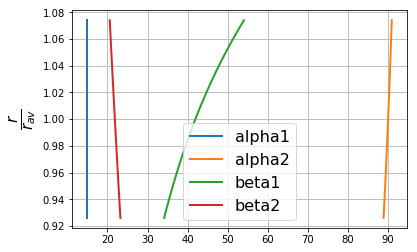

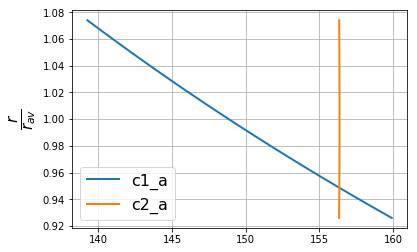

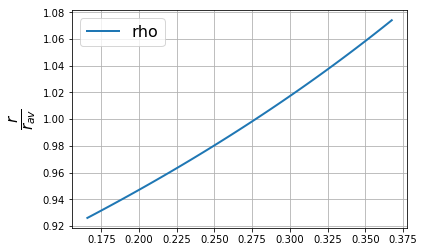

In [530]:
%matplotlib inline
stage1_prof.plot_parameter_distribution(['alpha1', 'alpha2', 'beta1', 'beta2'], figsize=(6, 4),
                                        filename=os.path.join(os.path.join(config.plots_dir, 
                                                                           '%s_profiling_angles.png' % st1_prefix)))
stage1_prof.plot_parameter_distribution(['c1_a', 'c2_a'],  figsize=(6, 4), 
                                        filename=os.path.join(os.path.join(config.plots_dir, 
                                                                           '%s_profiling_velocities.png' % st1_prefix)))
stage1_prof.plot_parameter_distribution(['rho'],  figsize=(6, 4), 
                                        filename=os.path.join(os.path.join(config.plots_dir, 
                                                                           '%s_profiling_rho.png' % st1_prefix)))

### Газодинамические параметры на втулочом сечении

In [531]:
st1_in_params = get_gas_dynamic_params(stage1_prof, 0.5 * stage1_prof.D1_in)
st1_in_params

,Name,Value
0,"r, мм",313.500000
1,rho,0.165793
2,"c1, м/с",617.976080
3,"c1_a, м/с",159.914155
4,"c1_u, м/с",596.927046
5,"alpha1, град",14.997137
6,"w1, м/с",284.904059
7,"w1_a, м/с",159.914155
8,"w1_u, м/с",235.791827
9,"beta1, град",34.145143


### Газодинамические параметры на среднем сечении

In [532]:
st1_av_params = get_gas_dynamic_params(stage1_prof, 0.5 * stage1_prof.D1_av)
st1_av_params

,Name,Value
0,"r, мм",338.600000
1,rho,0.277284
2,"c1, м/с",575.199444
3,"c1_a, м/с",148.844811
4,"c1_u, м/с",555.607435
5,"alpha1, град",14.997137
6,"w1, м/с",222.670857
7,"w1_a, м/с",148.844811
8,"w1_u, м/с",165.612599
9,"beta1, град",41.947712


### Газодинамические параметры на периферийном сечении

In [533]:
st1_out_params = get_gas_dynamic_params(stage1_prof, 0.5 * stage1_prof.D1_out)
st1_out_params

,Name,Value
0,"r, мм",363.600000
1,rho,0.367425
2,"c1, м/с",538.133829
3,"c1_a, м/с",139.253313
4,"c1_u, м/с",519.804322
5,"alpha1, град",14.997137
6,"w1, м/с",171.995235
7,"w1_a, м/с",139.253313
8,"w1_u, м/с",100.949868
9,"beta1, град",54.060257


### Треугольники скоростей

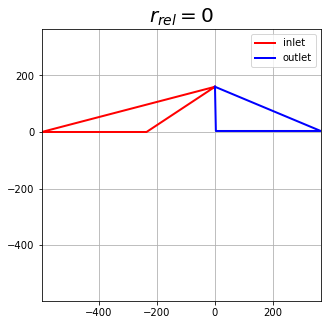

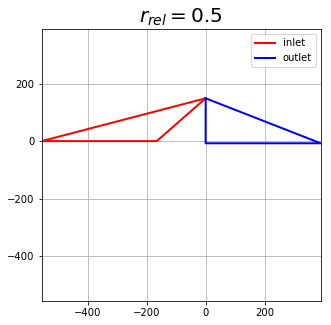

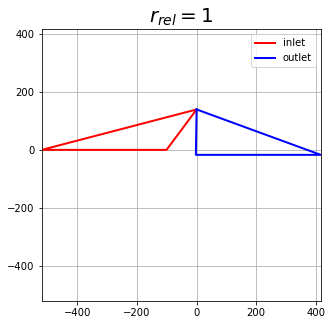

In [534]:
%matplotlib inline
stage1_prof.plot_velocity_triangles(r_rel=(0, 0.5, 1), figsize=(5, 5))

### Совмещенный график сечений

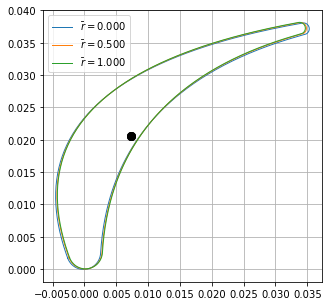

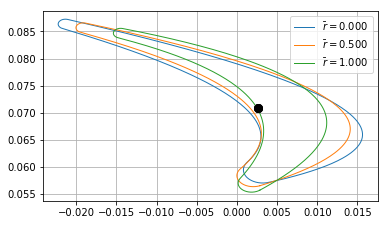

In [535]:
%matplotlib inline
stage1_prof.plot_sa_sections(figsize=(5, 5))
stage1_prof.plot_rk_sections(figsize=(6, 3.5))

### Втулочное сечение 

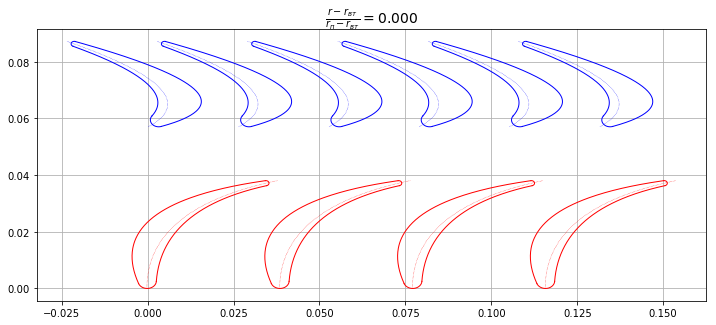

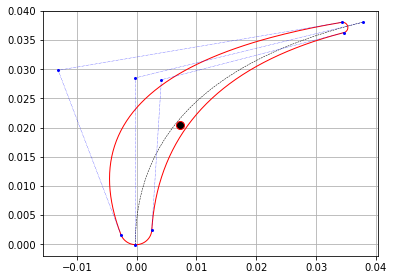

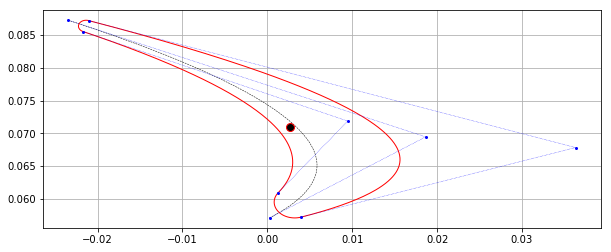

In [536]:
%matplotlib inline
stage1_prof.plot_profile_2d(section_number=0, width_rel=4, figsize=(12, 5))
st1_sa_sec_in.plot(figsize=(6.0, 4.5))
st1_rk_sec_in.plot(figsize=(10, 4))

### Геометрические параметры СА на втулочном сечении

In [537]:
st1_sa_sec_in_params = get_section_geom_params(st1_sa_sec_in, stage1_prof)
st1_sa_sec_in_params

,Name,Value
0,"alpha1, град",90.000000
1,"delta1, град",0.029478
2,"alpha1_л, град",89.970522
3,"gamma1, град",24.000000
4,"gamma1_к, град",3.600000
5,"gamma1_c, град",20.400000
6,"alpha2, град",14.997137
7,"delta2, град",0.920092
8,"alpha2_л, град",14.077045
9,"gamma2, град",5.000000


### Геометрические параметры РК на втулочном сечении

In [538]:
st1_rk_sec_in_params = get_section_geom_params(st1_rk_sec_in, stage1_prof)
st1_rk_sec_in_params

,Name,Value
0,"alpha1, град",34.145143
1,"delta1, град",0.208012
2,"alpha1_л, град",33.937131
3,"gamma1, град",35.000000
4,"gamma1_к, град",19.250000
5,"gamma1_c, град",15.750000
6,"alpha2, град",23.233815
7,"delta2, град",0.298617
8,"alpha2_л, град",22.935199
9,"gamma2, град",5.000000


### Среднее сечение

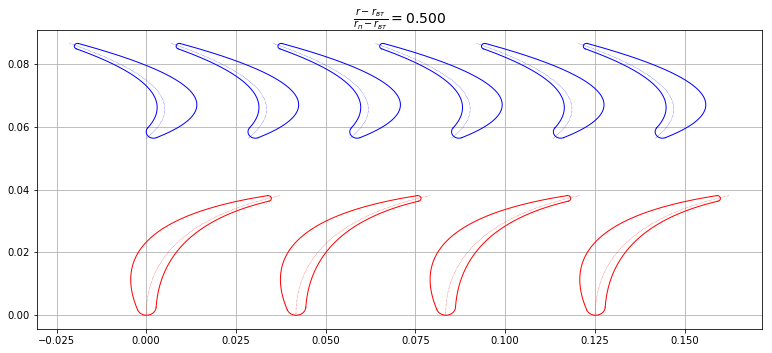

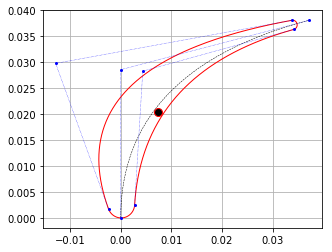

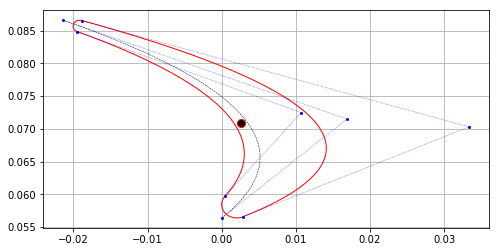

In [539]:
%matplotlib inline
stage1_prof.plot_profile_2d(section_number=3, width_rel=4, figsize=(13, 5.5))
st1_sa_sec_av.plot(figsize=(5, 4))
st1_rk_sec_av.plot(figsize=(8, 4))

### Геометрические параметры СА на среднем сечении

In [540]:
st1_sa_sec_av_params = get_section_geom_params(st1_sa_sec_av, stage1_prof)
st1_sa_sec_av_params

,Name,Value
0,"alpha1, град",90.000000
1,"delta1, град",0.029478
2,"alpha1_л, град",89.970522
3,"gamma1, град",24.000000
4,"gamma1_к, град",3.600000
5,"gamma1_c, град",20.400000
6,"alpha2, град",14.997137
7,"delta2, град",0.658245
8,"alpha2_л, град",14.338892
9,"gamma2, град",5.000000


### Геометрические параметры РК на среднем сечении

In [541]:
st1_rk_sec_av_params = get_section_geom_params(st1_rk_sec_av, stage1_prof)
st1_rk_sec_av_params

,Name,Value
0,"alpha1, град",41.947712
1,"delta1, град",0.158051
2,"alpha1_л, град",41.789661
3,"gamma1, град",27.000000
4,"gamma1_к, град",9.450000
5,"gamma1_c, град",17.550000
6,"alpha2, град",21.850264
7,"delta2, град",0.317469
8,"alpha2_л, град",21.532795
9,"gamma2, град",5.000000


### Периферийное сечение

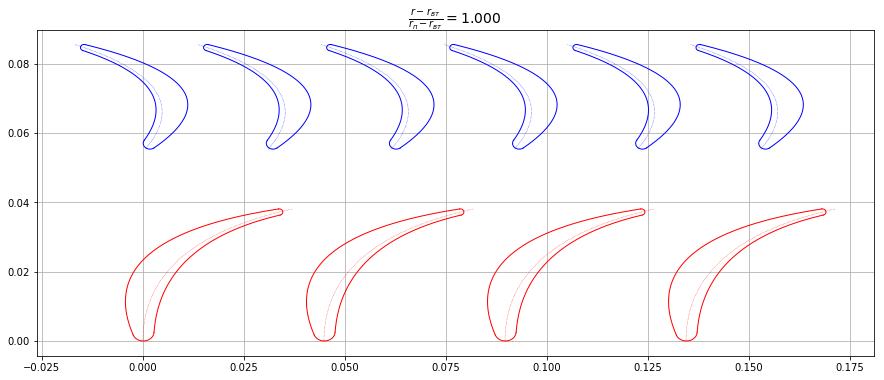

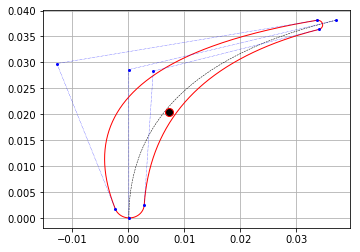

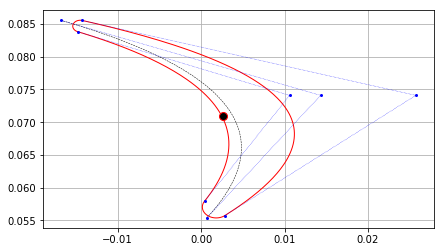

In [542]:
%matplotlib inline
stage1_prof.plot_profile_2d(section_number=6, width_rel=4, figsize=(15, 6))
st1_sa_sec_out.plot(figsize=(5.5, 4))
st1_rk_sec_out.plot(figsize=(7, 4))

### Геометрические параметры СА на периферийном сечении

In [543]:
st1_sa_sec_out_params = get_section_geom_params(st1_sa_sec_out, stage1_prof)
st1_sa_sec_out_params

,Name,Value
0,"alpha1, град",90.000000
1,"delta1, град",0.029478
2,"alpha1_л, град",89.970522
3,"gamma1, град",24.000000
4,"gamma1_к, град",3.600000
5,"gamma1_c, град",20.400000
6,"alpha2, град",14.997137
7,"delta2, град",0.557873
8,"alpha2_л, град",14.439265
9,"gamma2, град",5.000000


### Геометрические параметры РК на периферийном сечении

In [544]:
st1_rk_sec_out_params = get_section_geom_params(st1_rk_sec_out, stage1_prof)
st1_rk_sec_out_params

,Name,Value
0,"alpha1, град",54.060257
1,"delta1, град",0.117904
2,"alpha1_л, град",53.942354
3,"gamma1, град",19.000000
4,"gamma1_к, град",3.800000
5,"gamma1_c, град",15.200000
6,"alpha2, град",20.582592
7,"delta2, град",0.352287
8,"alpha2_л, град",20.230305
9,"gamma2, град",5.000000


## Результаты для ступени 2

In [545]:
st2_res = pd.DataFrame.from_dict({'Name': ['z_са',
                                          '(t/b)_са',
                                          'z_рк',
                                          '(t/b)_рк',
                                          ], 
                                  'Value': [stage2_prof.z_sa,
                                           stage2_prof.t_rel_av_sa,
                                           stage2_prof.z_rk,
                                           stage2_prof.t_rel_av_rk]})

st2_res

,Name,Value
0,z_са,47.000000
1,(t/b)_са,0.805520
2,z_рк,86.000000
3,(t/b)_рк,0.752817


### Распределения параметров по радиусу

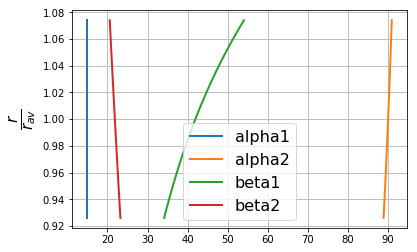

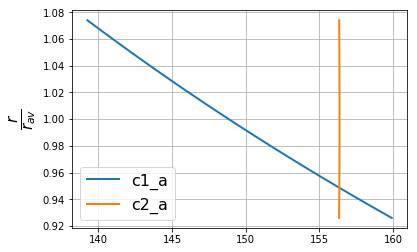

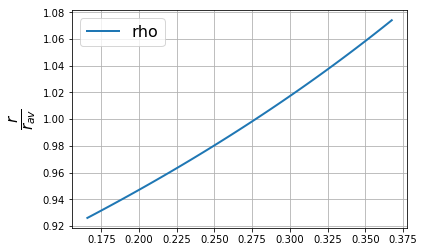

In [546]:
%matplotlib inline
stage1_prof.plot_parameter_distribution(['alpha1', 'alpha2', 'beta1', 'beta2'], figsize=(6, 4),
                                        filename=os.path.join(os.path.join(config.plots_dir, 
                                                                           '%s_profiling_angles.png' % st2_prefix)))
stage1_prof.plot_parameter_distribution(['c1_a', 'c2_a'],  figsize=(6, 4), 
                                        filename=os.path.join(os.path.join(config.plots_dir, 
                                                                           '%s_profiling_velocities.png' % st2_prefix)))
stage1_prof.plot_parameter_distribution(['rho'],  figsize=(6, 4), 
                                        filename=os.path.join(os.path.join(config.plots_dir, 
                                                                           '%s_profiling_rho.png' % st2_prefix)))

### Газодинамические параметры на втулочном сечении

In [547]:
st2_in_params = get_gas_dynamic_params(stage2_prof, 0.5 * stage2_prof.D1_in)
st2_in_params

,Name,Value
0,"r, мм",312.500000
1,rho,0.006206
2,"c1, м/с",758.893892
3,"c1_a, м/с",243.512176
4,"c1_u, м/с",718.764050
5,"alpha1, град",18.716017
6,"w1, м/с",433.628486
7,"w1_a, м/с",243.512176
8,"w1_u, м/с",358.797274
9,"beta1, град",34.164352


### Газодинамические параметры на среднем сечении

In [548]:
st2_av_params = get_gas_dynamic_params(stage2_prof, 0.5 * stage2_prof.D1_av)
st2_av_params

,Name,Value
0,"r, мм",346.300000
1,rho,0.173596
2,"c1, м/с",692.034509
3,"c1_a, м/с",222.058486
4,"c1_u, м/с",655.440150
5,"alpha1, град",18.716017
6,"w1, м/с",339.263487
7,"w1_a, м/с",222.058486
8,"w1_u, м/с",256.495112
9,"beta1, град",40.884101


### Газодинамические параметры на периферийном сечении

In [549]:
st2_out_params = get_gas_dynamic_params(stage2_prof, 0.5 * stage2_prof.D1_out)
st2_out_params

,Name,Value
0,"r, мм",380.200000
1,rho,0.300865
2,"c1, м/с",636.518753
3,"c1_a, м/с",204.244714
4,"c1_u, м/с",602.860033
5,"alpha1, град",18.716017
6,"w1, м/с",262.526244
7,"w1_a, м/с",204.244714
8,"w1_u, м/с",164.936732
9,"beta1, град",51.077576


### Треугольники скоростей

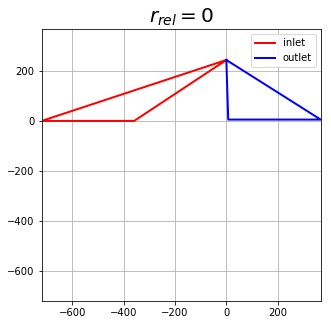

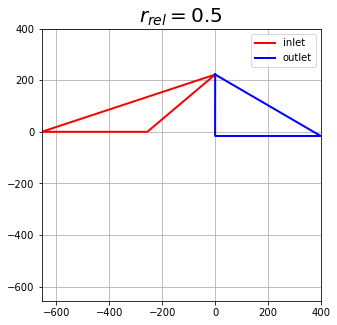

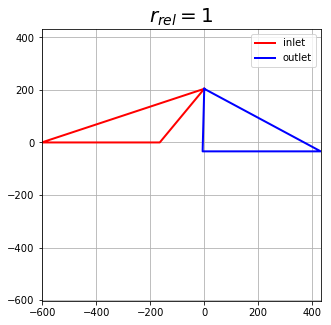

In [550]:
%matplotlib inline
stage2_prof.plot_velocity_triangles(r_rel=(0, 0.5, 1), figsize=(5, 5))

### Совмещенный график сечений

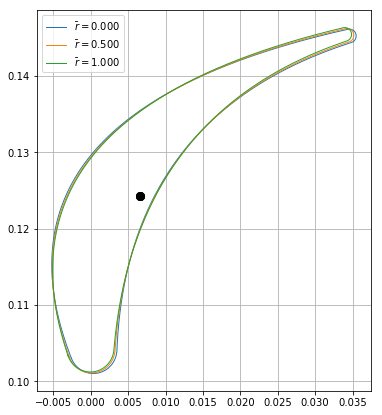

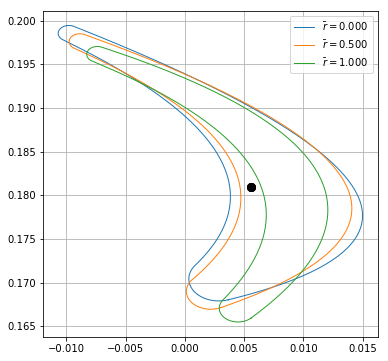

In [551]:
stage2_prof.plot_sa_sections(figsize=(6, 7))
stage2_prof.plot_rk_sections(figsize=(6, 6))

### Втулочное сечение

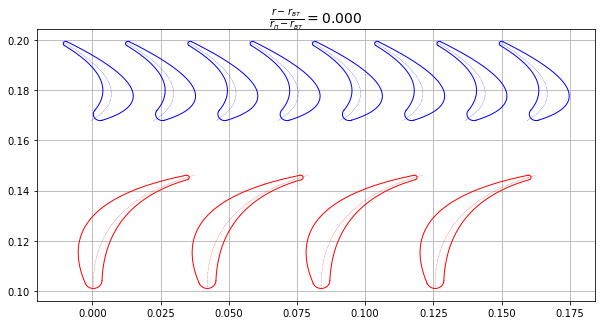

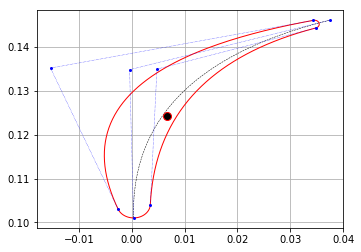

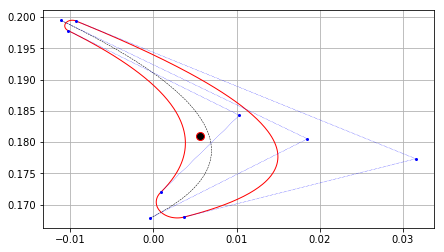

In [552]:
%matplotlib inline
stage2_prof.plot_profile_2d(section_number=0, width_rel=4, figsize=(10, 5))
st2_sa_sec_in.plot(figsize=(5.5, 4))
st2_rk_sec_in.plot(figsize=(7, 4))

### Геометрические параметры СА на втулочном сечении

In [553]:
st2_sa_sec_in_params = get_section_geom_params(st2_sa_sec_in, stage2_prof)
st2_sa_sec_in_params

,Name,Value
0,"alpha1, град",88.833317
1,"delta1, град",0.108072
2,"alpha1_л, град",88.725246
3,"gamma1, град",24.000000
4,"gamma1_к, град",3.600000
5,"gamma1_c, град",20.400000
6,"alpha2, град",18.716017
7,"delta2, град",2.123879
8,"alpha2_л, град",16.592137
9,"gamma2, град",5.000000


### Геометрические параметры РК на втулочном сечении

In [554]:
st2_rk_sec_in_params = get_section_geom_params(st2_rk_sec_in, stage2_prof)
st2_rk_sec_in_params

,Name,Value
0,"alpha1, град",34.164352
1,"delta1, град",0.422075
2,"alpha1_л, град",33.742277
3,"gamma1, град",34.000000
4,"gamma1_к, град",18.700000
5,"gamma1_c, град",15.300000
6,"alpha2, град",32.955293
7,"delta2, град",0.434302
8,"alpha2_л, град",32.520991
9,"gamma2, град",5.000000


### Среднее сечение

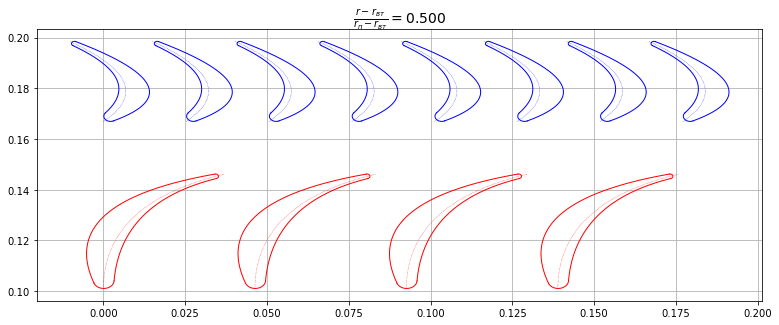

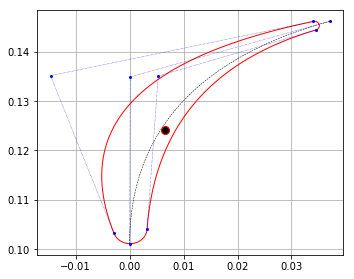

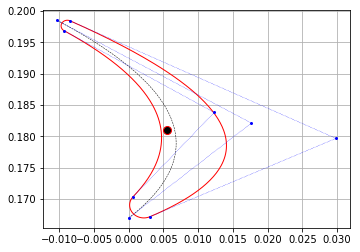

In [555]:
%matplotlib inline
stage2_prof.plot_profile_2d(section_number=3, width_rel=4, figsize=(13, 5))
st2_sa_sec_av.plot(figsize=(5.5, 4.5))
st2_rk_sec_av.plot(figsize=(5.5, 4))

### Геометрические параметры СА на среднем сечении

In [556]:
st2_sa_sec_av_params = get_section_geom_params(st2_sa_sec_av, stage2_prof)
st2_sa_sec_av_params

,Name,Value
0,"alpha1, град",90.314854
1,"delta1, град",0.108071
2,"alpha1_л, град",90.206784
3,"gamma1, град",24.000000
4,"gamma1_к, град",3.600000
5,"gamma1_c, град",20.400000
6,"alpha2, град",18.716017
7,"delta2, град",1.731131
8,"alpha2_л, град",16.984885
9,"gamma2, град",5.000000


### Геометрические параметры РК на среднем сечении

In [557]:
st2_rk_sec_av_parmas = get_section_geom_params(st2_rk_sec_av, stage2_prof)
st2_rk_sec_av_parmas

,Name,Value
0,"alpha1, град",40.884101
1,"delta1, град",0.272340
2,"alpha1_л, град",40.611761
3,"gamma1, град",24.000000
4,"gamma1_к, град",8.400000
5,"gamma1_c, град",15.600000
6,"alpha2, град",30.861389
7,"delta2, град",0.508311
8,"alpha2_л, град",30.353078
9,"gamma2, град",5.000000


### Периферийное сечение

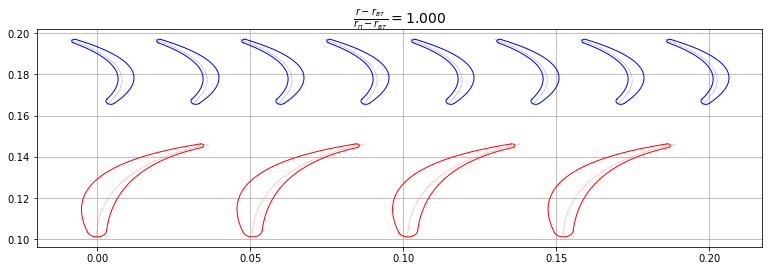

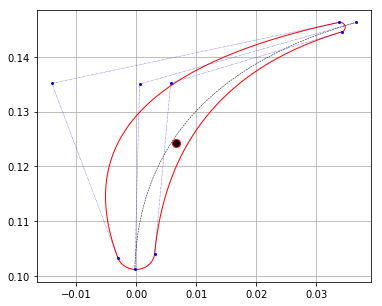

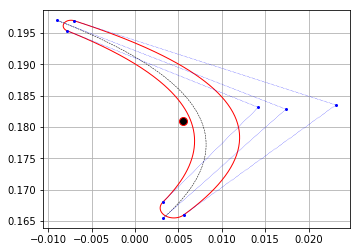

In [558]:
%matplotlib inline
stage2_prof.plot_profile_2d(section_number=6, width_rel=4, figsize=(13, 4))
st2_sa_sec_out.plot(figsize=(6.0, 5))
st2_rk_sec_out.plot(figsize=(5.5, 4))

### Геометрические параметры СА на периферийном сечении

In [559]:
st2_sa_sec_out_params = get_section_geom_params(st2_sa_sec_out, stage2_prof)
st2_sa_sec_out_params

,Name,Value
0,"alpha1, град",91.423994
1,"delta1, град",0.108067
2,"alpha1_л, град",91.315927
3,"gamma1, град",24.000000
4,"gamma1_к, град",3.600000
5,"gamma1_c, град",20.400000
6,"alpha2, град",18.716017
7,"delta2, град",1.370779
8,"alpha2_л, град",17.345238
9,"gamma2, град",5.000000


### Геометрические параметры РК на периферийном сечении

In [560]:
st2_rk_sec_out_params = get_section_geom_params(st2_rk_sec_out, stage2_prof)
st2_rk_sec_out_params

,Name,Value
0,"alpha1, град",51.077576
1,"delta1, град",0.204550
2,"alpha1_л, град",50.873026
3,"gamma1, град",9.000000
4,"gamma1_к, град",3.150000
5,"gamma1_c, град",5.850000
6,"alpha2, град",28.872033
7,"delta2, град",0.588178
8,"alpha2_л, град",28.283854
9,"gamma2, град",5.000000


## Проточная часть в 3d

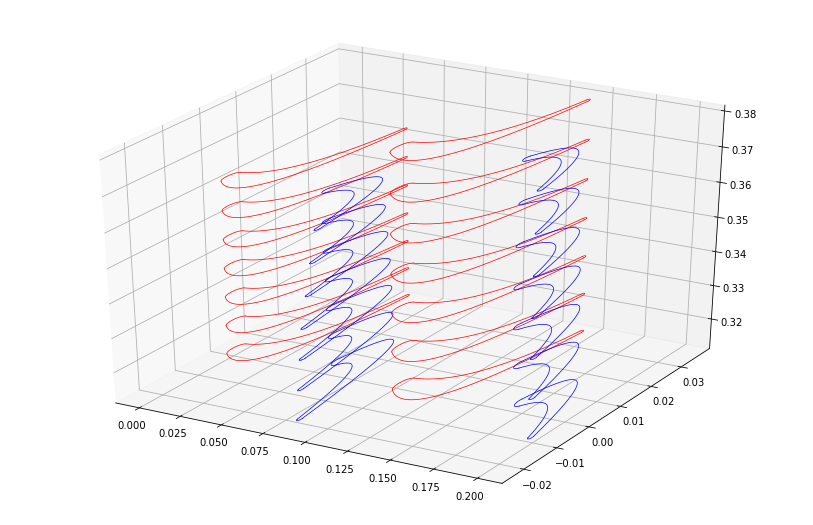

In [561]:
%matplotlib inline
profiler.plot_3d()